# Masking


In [1]:
from skimage.morphology import skeletonize, dilation, opening, square, disk
from skimage.morphology import skeletonize, dilation, erosion, opening, closing, square, disk
from skimage.morphology import remove_small_holes, remove_small_objects # for filling the holes and denoising
import matplotlib.pyplot as plt

import numpy as np
import math
from skimage import io


from skimage.filters import threshold_mean#for binarising
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_minimum, threshold_triangle, threshold_mean, threshold_li


# For watershed
from scipy import ndimage as ndi#for distance
from skimage.feature import peak_local_max 
from skimage.segmentation import watershed 
from skimage import measure #measure objects


from skimage.color import rgb2lab # For converting RGB to LAB
from skimage.color import gray2rgb # For converting gray to RGB

#for max & min filter
from skimage.morphology import disk, ball
from skimage.filters.rank import mean, maximum, minimum 
from skimage import img_as_ubyte as byte_convo #Convert an image to unsigned byte format, with values in [0, 255].


In [2]:
def get_image(name):
    """ Using the skimage.io import the image with the file name.
    This function returns the gray image as numpy array """
    
    #Getting the image  
    #filename = '../Images/'+name
    filename = name
    image_gray = io.imread(filename, as_gray = True) 
    image_RGB = io.imread(filename, as_gray = False) 
    
    return image_gray, image_RGB

In [3]:
def show_image(image, label ="Image:", size=(6,2), cmap='viridis'):
    """This function shows/plots the given image."""
    plt.subplots(1,1,figsize=size)
    plt.title(label = label, fontsize=12)
    plt.imshow(image, cmap=cmap) 
    plt.show()

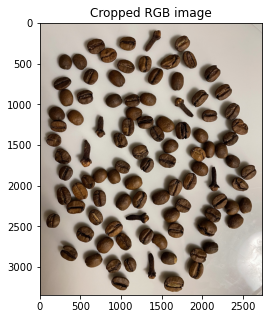

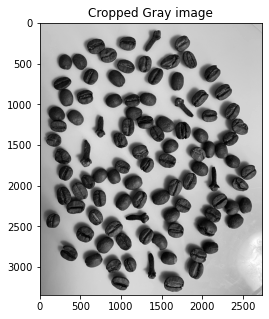

In [4]:
image_gray, image_RGB = get_image("coffeebeans.jpg")
# show_image(image, "Original Binary image")

#cropping the head
image_gray = image_gray[330:3670, 130:2860]    #[Row Y, COL, X]
image_RGB = image_RGB[330:3670, 130:2860]   #[Row Y, COL, X]

show_image(image_RGB, label ="Cropped RGB image", size=(10,5))
show_image(image_gray, label ="Cropped Gray image", size=(10,5), cmap='gray')

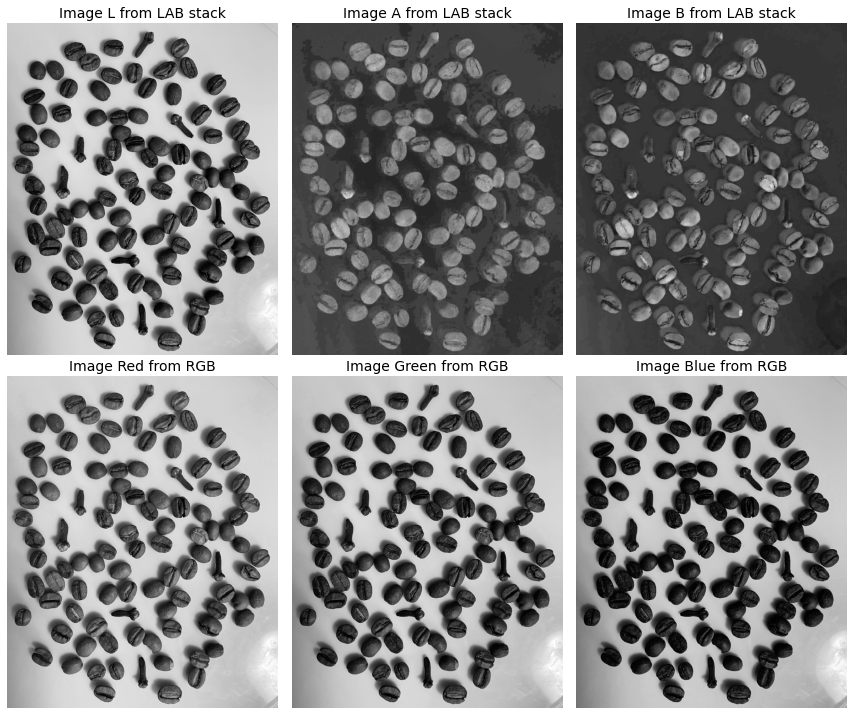

In [5]:
# Splitting the RGB color channels
img_red = image_RGB [:,:,0] # pull out the red channel
img_green = image_RGB [:,:,1] # pull out the green channel
img_blue = image_RGB [:,:,2] # pull out the blue channel

# Splitting the LAB Stack
img_lab = rgb2lab(image_RGB)# Converting from RGB to LAB stack
img_l = img_lab[:,:,0] # pull out L channel
img_a = img_lab[:,:,1] # pull out A channel
img_b = img_lab[:,:,2] # pull out B channel



# Displaying differnt color channels of the original image
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))

ax[0,0].imshow(img_l, cmap='gray')
ax[0,0].set_title('Image L from LAB stack', fontsize = 14)

ax[0,1].imshow(img_a, cmap='gray')
ax[0,1].set_title('Image A from LAB stack', fontsize = 14)

ax[0,2].imshow(img_b, cmap='gray')
ax[0,2].set_title('Image B from LAB stack', fontsize = 14)


ax[1,0].imshow(img_red, cmap='gray')
ax[1,0].set_title('Image Red from RGB', fontsize = 14)

ax[1,1].imshow(img_green, cmap='gray')
ax[1,1].set_title('Image Green from RGB', fontsize = 14)

ax[1,2].imshow(img_blue, cmap='gray')
ax[1,2].set_title('Image Blue from RGB', fontsize = 14)

for row in ax:
    for col in row:
        col.axis('off')

fig.tight_layout()
plt.show()

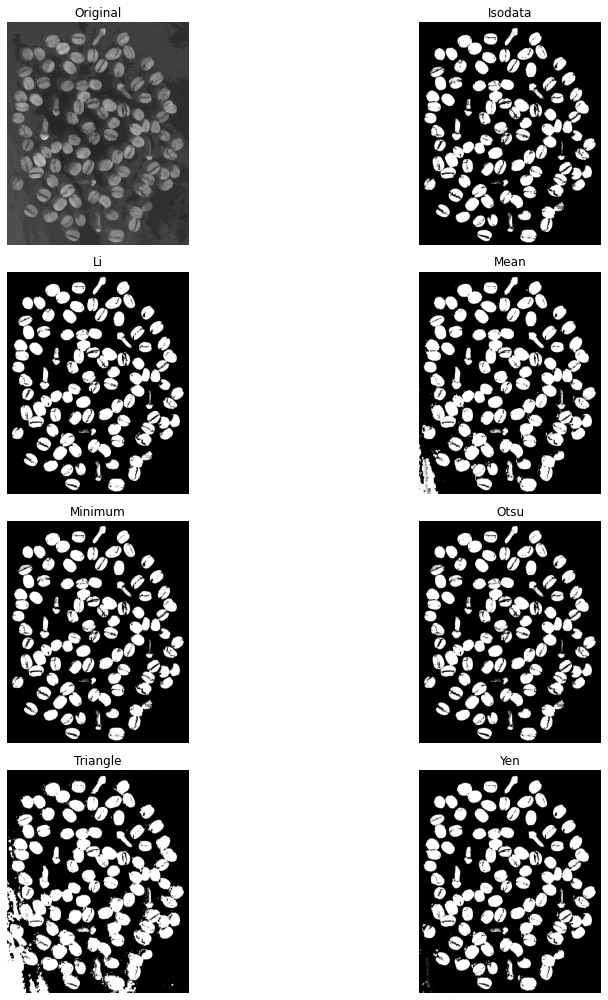

In [6]:
# Trying to find the best thresholding method for binarising the image (without shadows)
fig, ax = try_all_threshold(img_a, figsize=(15, 14), verbose=False)
plt.show()

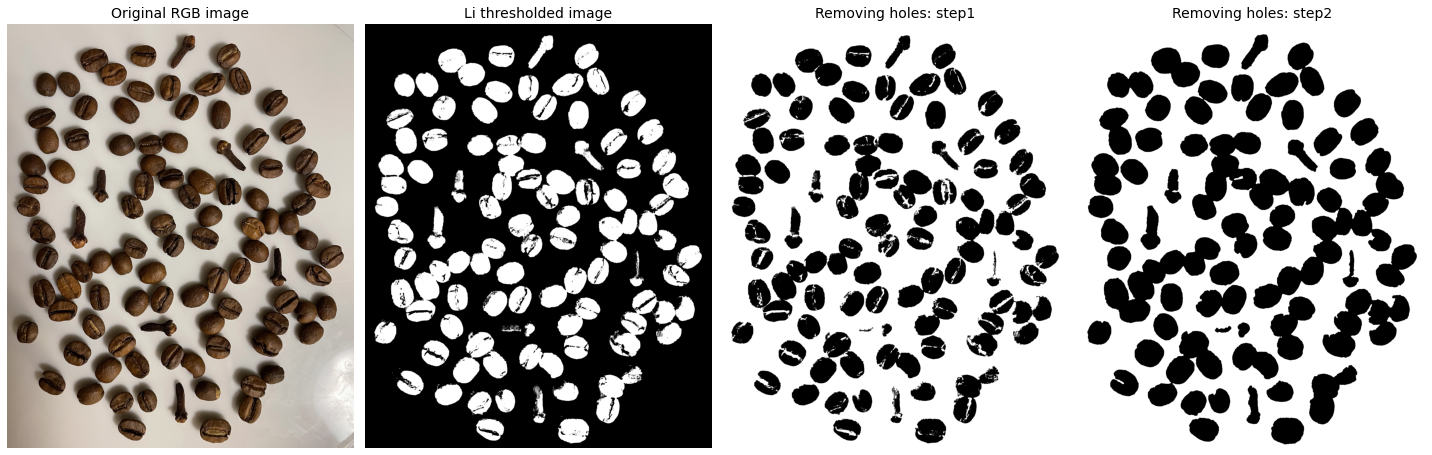

In [7]:
# Binarising the image using the Li filter
thresh = threshold_li(img_a)
binary_li = img_a > thresh
# show_image(binary_li, "Li thresholded image", (12,5), cmap='gray')


# Filling the holes of the objects in the binary image
# Step1: using remove_small_holes
inverted_binary_li = np.invert(binary_li)
holes_filled = remove_small_holes(inverted_binary_li, area_threshold = 500)

# Step2: using dilation & erosion
mask_without_shadow = np.invert(holes_filled.copy()) 
for _ in range(4):
    mask_without_shadow = dilation(mask_without_shadow, disk(3))
for _ in range(4):
    mask_without_shadow = erosion(mask_without_shadow, disk(1))
    
mask_without_shadow = remove_small_holes(mask_without_shadow, area_threshold = 800)    
mask_without_shadow = np.invert(mask_without_shadow)*1.0



# Displaying the images
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 16))

ax[0].imshow(image_RGB)
ax[0].set_title('Original RGB image', fontsize = 14)

ax[1].imshow(binary_li, cmap='gray')
ax[1].set_title("Li thresholded image", fontsize = 14)

ax[2].imshow(holes_filled, cmap='gray')
ax[2].set_title("Removing holes: step1", fontsize = 14)

ax[3].imshow(mask_without_shadow, cmap='gray')
ax[3].set_title("Removing holes: step2", fontsize = 14)

for row in ax:
    row.axis('off')

fig.tight_layout()
plt.show()

In [8]:

# ## Plotting the image
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 16))

# ax[0].imshow(image_RGB, cmap='gray')
# # ax[0,0].set_title('img_l', fontsize = 14)

# ax[1].imshow(holes_filled, cmap='gray')
# # ax[1,0].set_title('img_red', fontsize = 14)

# for row in ax:
#     row.axis('off')

# fig.tight_layout()
# plt.show()

In [9]:
# print(mask.shape)

In [10]:
# Converting the mask from gray to RGB format
RGB_mask_without_shadow = gray2rgb(mask_without_shadow)
# print(RGB_mask.shape)
# plt.imshow(RGB_mask)

In [11]:
# print(RGB_mask.shape)
# print(image_RGB.shape)

# ## Plotting the image
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 16))

# ax[0].imshow(masked_image, cmap='gray')
# # ax[0,0].set_title('img_l', fontsize = 14)

# ax[1].imshow(RGB_mask, cmap='gray')
# # ax[1,0].set_title('img_red', fontsize = 14)

# for row in ax:
#     row.axis('off')

# fig.tight_layout()
# plt.show()

In [12]:
# Function for creating the mask image which takes 2 images as parameters
def masking_image(image_RGB, RGB_mask):
    masked_image = image_RGB.copy() # Creating a copy of the RGB image
    shape = np.shape(RGB_mask)
    for i in range(shape[0]):
        for j in range(shape[1]):
            a, b, c = RGB_mask[i, j]
            if (a == 1.0) and (b== 1.0) and (c==1.0): # checking if the pixel from the mask is white
                masked_image[i, j] = [255, 255, 255] # Setting the pixel of the RGB to white
    return masked_image

In [13]:
# Generating the masked image without shadows
without_shadow_masked = masking_image(image_RGB, RGB_mask_without_shadow)

# show_image(without_shadow_masked, "masked_answer", (20,15))

In [14]:
# print(without_shadow_masked.shape)
# print(without_shadow_masked.shape[2])

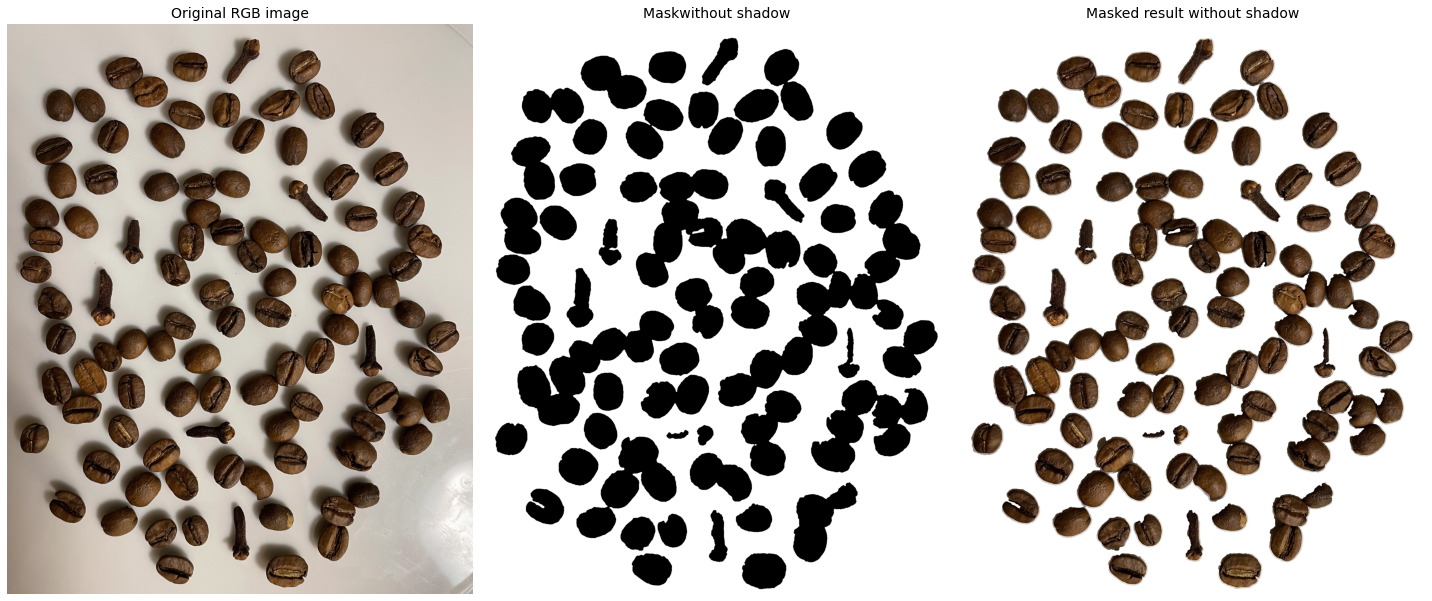

In [17]:
# Displaying the final masked results (without shadows)
def display_mask_results(image_RGB, mask, masked_answer, masking_type = ""):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 16))

    ax[0].imshow(image_RGB)
    ax[0].set_title('Original RGB image', fontsize = 14)

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask"+ masking_type, fontsize = 14)

    ax[2].imshow(masked_answer, cmap='gray')
    ax[2].set_title("Masked result " + masking_type , fontsize = 14)


    for row in ax:
        row.axis('off')

    fig.tight_layout()
    plt.show()
    
#Displaying the masked results
display_mask_results(image_RGB, RGB_mask_without_shadow, without_shadow_masked, masking_type = "without shadow")

# Masking in Image J
- image- type- 8 bit - adjust- triangle- autothreshold- 
- edit-invert [Fill holes ONLY WORKS WHEN THE OBJECT IS WHITE]
- process-binary-fill holes 
- edit-invert [For masking objects needs to be black/0]
- Process- image- calculator - Original Color image(image1) OR Mask (image2) 